In [ ]:
#!pip install underthesea
#!pip install fasttext
!pip install pyvi
#from underthesea import word_tokenize
from  pyvi import ViTokenizer
from  IPython.display import clear_output
import string
import os 
from PIL import Image
import numpy as np
import time
import random
import matplotlib.pyplot as plt
from gensim.test.utils import datapath
import pickle
from sklearn.model_selection import train_test_split
import time

import torch 
import torchvision
import torch.nn as nn
from  torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import gensim
clear_output()

In [ ]:
# unzip flick8k images 
!unzip /content/drive/MyDrive/DeepLearning/TH/Data/archive.zip
clear_output()

# create and save

In [ ]:
# setup device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
#token_path = 'Data/flick8kVN.txt'
token_path = '/content/drive/MyDrive/DeepLearning/TH/Data/flick8kVN.txt'
image_path = '/content/Images/'
train_image_path = '/content/drive/MyDrive/DeepLearning/TH/CuoiKy/images_train.txt'
test_image_path = '/content/drive/MyDrive/DeepLearning/TH/CuoiKy/images_test.txt'

In [ ]:
#read flick8VN.text
with open(token_path, 'r') as f:
  doc = f.read()
print(doc[:500])

1000268201_693b08cb0e.jpg # 0 Một đứa trẻ mặc váy hồng đang trèo lên một bộ cầu thang theo lối vào.
1000268201_693b08cb0e.jpg # 1 Một cô gái đi vào một tòa nhà bằng gỗ.
1000268201_693b08cb0e.jpg # 2 Một cô bé trèo vào nhà chơi bằng gỗ.
1000268201_693b08cb0e.jpg # 3 Một cô bé leo lên cầu thang đến nhà chơi của mình.
1000268201_693b08cb0e.jpg # 4 Một cô bé mặc váy hồng đi vào cabin gỗ.
1001773457_577c3a7d70.jpg # 0 Một con chó đen và một con chó đốm đang chiến đấu
1001773457_577c3a7d70.jpg # 1 Một


In [ ]:
# đưa các key và caption vào dictionary
descriptions = dict()
for line in doc.split('\n'):
  tokens = line.split()
  image_id = ' '.join(tokens[0:3])
  image_desc = ' '.join(tokens[4:])
  descriptions[image_id]= image_desc

descriptions['1000268201_693b08cb0e.jpg # 0']

'đứa trẻ mặc váy hồng đang trèo lên một bộ cầu thang theo lối vào.'

In [ ]:
# Tách từ và xử lý cơ bản như loại bỏ kí tự đặc biệt, lower word
table = str.maketrans('', '', string.punctuation)
for key, description in descriptions.items():
    desc = [word.lower() for word in description.split()]
    desc = ' '.join([word.translate(table) for word in desc])
    desc = ViTokenizer.tokenize(desc)
    descriptions[key] = desc
  

In [ ]:
'vào.'.translate(table)

'vào'

In [ ]:
# tạo một lớp vocab để lấy các thông tin như kích thước bộ từ điển, 
class Vocab():
  def __init__(self):
    self.n_words = 3
    self.word2index = {'<startseq>':1,'<endseq>':2,'<pad>':0, '<none>':3}
    self.word2count = {}
    self.index2word = {1:'<startseq>',2:'<endseq>',0:'<pad>',3:'<none>'}
    self.max_length = 0

    self._word_count = {}
    
  def fit(self, all_train_caption, word_count_threshold = 10):
    # đêm số lần xuất hiện của mỗi từ để sau đó có thể lọc ra những từ có số lần xúất hiện > word_count_threshold
    for sentence in all_train_caption:
      for w in sentence.split(' '):
        if w not in self._word_count:
          self._word_count[w] = 0
        self._word_count[w] += 1

    # Thêm các từ vào từ điển và cập nhập các thông tin cơ bản của vocab
    for sentence in all_train_caption: 
      self.addSentence(sentence, word_count_threshold)
    
  def addSentence(self,sentence, word_count_threshold):
    sentence = sentence.split()
    if len(sentence)>self.max_length:
      self.max_length = len(sentence)
    for word in sentence:
      self.addWord(word,word_count_threshold)

  def addWord(self, word,word_count_threshold):
    if (word not in self.word2index) and self._word_count[word]>=word_count_threshold:
      self.word2index[word] = self.n_words
      self.word2count[word] = 1
      self.index2word[self.n_words] = word
      self.n_words += 1
    elif self._word_count[word] >word_count_threshold:
      self.word2count[word] += 1

In [ ]:
vocab = Vocab()
vocab.fit(list(descriptions.values()), 5)

In [ ]:
print('vocab_size = ', vocab.n_words)
vocab.word2index['cao'], vocab.index2word[535]

vocab_size =  2332


(333, 'an_toàn')

In [ ]:
# load pretrained ma trận embedding từ baomoi.window2.vn.model.bin
path_keyedvectors = '/content/drive/MyDrive/DeepLearning/TH/Data/baomoi.window2.vn.model.bin'
embeddings_index = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format( path_keyedvectors, binary = True)

In [ ]:
# tạo embedding matrix nhỏ hơn trên tập bộ từ điển vừa tạo 
embedding_dim = 300

embedding_matrix = np.zeros((vocab.n_words, embedding_dim), dtype=np.float32)
for i, word in vocab.index2word.items():
  if word in embeddings_index:
    embedding_vector = embeddings_index[word]
    embedding_matrix[i] = embedding_vector
  elif word == '<startseq>':
    embedding_matrix[i] = np.array([0.1]*embedding_dim)
  elif word == '<endseq>':
    embedding_matrix[i] = np.array([0.2]*embedding_dim)
  elif word == '<pad>':
    continue
  else :
     embedding_matrix[i] = np.array([0.3]*embedding_dim)

  
#+++++++++++++delete+++++++++++
del embeddings_index

In [ ]:
print('embedding_matrix.shape = ',embedding_matrix.shape)

embedding_matrix.shape =  (2332, 300)


In [ ]:
# load trước ảnh với kích thước 299*299 với kênh màu rgb
all_keys_description = set([j.split()[0] for j in list(descriptions.keys()) ])
all_image = [i for i in os.listdir(image_path) if i in all_keys_description]
images = {}
for name in all_image:
  images[name] = Image.open(os.path.join(image_path,name)).convert('RGB').resize((299,299))


# Lọc ra những description có ảnh trong thư mục
captions = {}
for key , values in descriptions.items():
  if key.split()[0] in list(images.keys()):
    captions[key] = values

('con chó đen và trắng nhảy lên trước một món đồ_chơi màu vàng',
 'con chó nhảy lên để bắt bóng trên một cánh đồng')

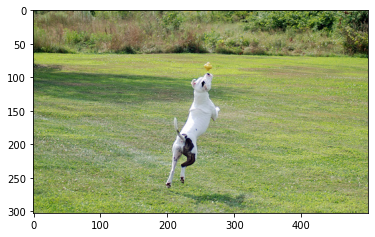

In [ ]:
im = Image.open(os.path.join(image_path,'1020651753_06077ec457.jpg'))
plt.imshow(im)
captions['1020651753_06077ec457.jpg # 1'],captions['1020651753_06077ec457.jpg # 2']

In [ ]:
# tạo dataset 
class FlickrDataset(Dataset):
  def __init__(self,captions, images,transforms = None):


    """
    descriptions: tat mo ta cua tat ca anh 
    keys : ten anh train 

    output : path_image
    description
    
    """

    self.captions = captions
    self.keys = list(captions.keys())
    self.transforms = transforms
    self.images =images


  def tensorFromSentence(self,sentence):
    sentence = '<startseq> '+sentence +' <endseq>' 
    indexes = []
    for word in sentence.split():
      if word in vocab.word2index:
        indexes.append(vocab.word2index[word])
    return torch.tensor(indexes, dtype = torch.long)
  def __getitem__(self, index):

    key = self.keys[index]
    #load description
    description_tensor = self.tensorFromSentence(self.captions[key])
    #load image
    image = self.images[key.split()[0]]
    if self.transforms is not None:
      image = self.transforms(image)
    

    return image, description_tensor
  def __len__(self):
    return len(self.keys)

In [ ]:
transform = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                 ])

untransform = transforms.Compose([
                                   transforms.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.225],[1/0.229,1/0.224,1/0.225]),
                                   transforms.ToPILImage()
                                   ])

dataset = FlickrDataset(captions ,images,transforms = transform)
dataset.__len__()

39646

In [ ]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [38000, 1646])

<startseq> con chó đen nổi lên khỏi mặt_nước với một quả bóng trắng trong miệng <endseq>
tensor([  1,  30,  31,  32, 502,  10, 208, 153,  38,  11, 143, 144,  42,  64,
        216,   2])


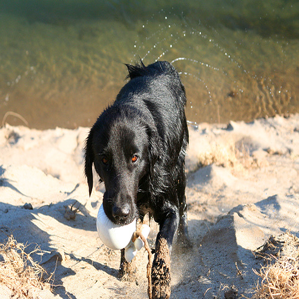

In [ ]:
img, cap = train_dataset[1]
print(' '.join([vocab.index2word[i.item()] for i in cap ]))
print(cap)
untransform(img)


In [ ]:
# hàm xử lý một batch (padding theo độ dài của batch giảm thiểu chi phí)
def collate_fcn(batch):
  imgs = [item[0].unsqueeze(0) for item in batch]
  imgs = torch.cat(imgs,dim=0)

  targets = [item[1] for item in batch]
  targets = pad_sequence(targets, batch_first=True, padding_value=vocab.word2index['<pad>'])
  return imgs,targets

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=2, collate_fn=collate_fcn)
test_dataloader = DataLoader(test_dataset, batch_size=32, num_workers=2,collate_fn=collate_fcn)

<startseq> người đàn_ông đang chơi guitar bên cạnh một người đàn_ông khác đang ngồi sau một chiếc xe đẩy màu xanh lá cây đeo mặt_nạ <endseq> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
tensor([   1,   79,   80,    8,   25, 1401,   93,   87,   11,   79,   80,   51,
           8,   59,  169,   11,  185,  213,  246,   37,  139,  284,  120,  106,
         895,    2,    0,    0,    0,    0,    0,    0,    0,    0])


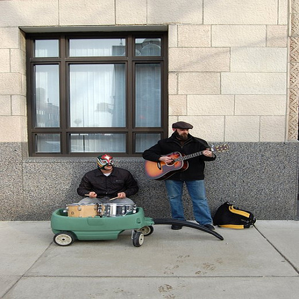

In [ ]:
img = next(iter(train_dataloader))[0][12]
cap = next(iter(train_dataloader))[1][12]
print(' '.join([vocab.index2word[i.item()] for i in cap ]))
print(cap)
untransform(img)

Mô hình Encode Decode với Bahdanau attention

In [ ]:
class EncoderCNN(nn.Module):

  def __init__(self):
    super(EncoderCNN, self).__init__()
    resnet = torchvision.models.resnet50(pretrained = True)
    for parma in resnet.parameters():
      parma.requires_grad_(False)
    
    modules = list(resnet.children())[:-2]
    self.resnet  = nn.Sequential(*modules)
  def forward(self, images):
    features =self.resnet(images)
    # batch_size, feature_maps, size, size,(image.size()= 3,299,299. ouput size = 10,10,2048)

    batch_size, feature_maps, size1, size2 = features.size()

    features = features.permute(0,2,3,1)
    features = features.view(batch_size, size1*size2, feature_maps)# batch_size, size*size, feature_maps
    return features

In [ ]:
class BahdanauAttention(nn.Module):
  def __init__(self, attention_dim, decoder_dim, encoder_dim):
    super(BahdanauAttention, self).__init__()
    self.attention_dim  = attention_dim 


    self.W_a = nn.Linear(encoder_dim, attention_dim)
    self.U_a = nn.Linear(decoder_dim, attention_dim)
    self.V_a = nn.Linear(attention_dim, 1)

  def forward(self, features, decoder_hidden):

    atten_1 = self.W_a(features)# batch_size, 100, attention_dim
    atten_2 = self.U_a(decoder_hidden.unsqueeze(1))# batch_size, 1, attention_dim

    atten_tan = torch.tanh(atten_1+atten_2)# batch_size, 100 ,hidden_dim
    atten_score = self.V_a(atten_tan)# batch_size, 100, 1
    
    atten_weight = F.softmax(atten_score, dim =1 )# batch_size, 100, 1
    context = torch.sum(atten_weight* features, dim =1 )# batch_size, num_features
    atten_weight = atten_weight.squeeze(dim =2 )#batch_size, 100
    return context, atten_weight

In [ ]:
class DecoderRNN(nn.Module):

  def __init__(self, attention_dim, embedding_dim, decoder_dim, encoder_dim,vocab_size,embedding_matrix ,p = 0.5):
    super(DecoderRNN, self).__init__()

    self.attention_dim = attention_dim
    self.embedding_dim = embedding_dim 
    self. decoder_dim = decoder_dim
    self.vocab_size= vocab_size
    self.encoder_dim = encoder_dim

    #self.sample_temp = 0.5

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.embedding.weight = nn.Parameter(torch.from_numpy(embedding_matrix))# sử dựng embedding matrix
    self.embedding.weight.requires_grad = False
    self.lstm = nn.LSTMCell(embedding_dim+encoder_dim, decoder_dim)
    self.fc = nn.Linear(decoder_dim, vocab_size)

    self.attention = BahdanauAttention(attention_dim, decoder_dim, encoder_dim)
    self.drop = nn.Dropout(p)

    self.init_h = nn.Linear(encoder_dim, decoder_dim)
    self.init_c = nn.Linear(encoder_dim, decoder_dim)
  
  def forward(self, captions, features, sample_prob = 0.0):
    embed = self.embedding(captions)#batch_size, len_seq, embedding_dim
    h,c = self.init_hidden(features)# batch_size, decoder_dim
    seq_len = captions.size(1)
    num_features = features.size(1)
    batch_size = features.size(0)

    outputs =  torch.zeros(batch_size, seq_len, self.vocab_size).to(device)
    atten_weights = torch.zeros(batch_size, seq_len, num_features).to(device)

    for t in range(seq_len):

      context, atten_weight = self.attention(features,h)
      lstm_input = torch.cat([embed[:,t,:], context],dim =1)# batch_size, embedding_dim+attention_dim
      h,c = self.lstm(lstm_input, (h,c))
      
      output = self.fc(self.drop(h))# batch_size, embedidng_dim

      outputs[:,t,:] =  output
      atten_weights[:,t,:] = atten_weight
    return outputs, atten_weights



    #   sample_prob = 0.0 if t==0 else 5.0
    #   use_sampling = np.random.random()<sample_prob
    #   #Teacher forcing
    #   if use_sampling == False:
    #     word_embed = embed[:,t,:]
    #   context, atten_weight = self.attention(features, h)
    #   input_concat = torch.cat([word_embed, context], dim = 1)
    #   h,c  = self.lstm(input_concat,(h,c))
    #   h = self.drop(h)
    #   output = self.fc(h)

    #   if use_sampling == True:
    #     scaled_output = output/self.sample_temp
    #     scoring = F.log_softmax(scaled_output, dim =1 )
    #     top_idx = scoring.topk(1)[1]
    #     word_embed = self.embedding(top_idx).squeeze(1)
    #   outputs[:,t,:] = output
    #   atten_weights[:,t,:] = atten_weight
    # return outputs, atten_weights


  def init_hidden(self, features):
    mean_encoder_out = torch.mean(features, dim =1 )#batch, encoder_dim
    h0 = self.init_h(mean_encoder_out)
    c0 = self.init_c(mean_encoder_out)
    return h0, c0

In [ ]:
class EncoderDecoder(nn.Module):
  def __init__(self, attention_dim, embedding_dim, decoder_dim, encoder_dim, vocab_size, embedding_matrix):
    super(EncoderDecoder, self).__init__()
    self.encoder = EncoderCNN()
    self.decoder = DecoderRNN(attention_dim, embedding_dim, decoder_dim, encoder_dim, vocab_size, embedding_matrix)
  def forward(self, images, captions):
    features = self.encoder(images)
    outputs, atten_weights = self.decoder(captions = captions, features = features)
    return outputs, atten_weights
  def image_caption(self, image, max_len =20):

    seq = []
    input = self.decoder.embedding(torch.tensor(vocab.word2index['<startseq>']).to(device)).view(1,-1)#1, embedding_size

    
    features= self.encoder(image)
    h,c = self.decoder.init_hidden(features)
    for i in range(max_len):
      context, _ = self.decoder.attention(features, h)
      input_concat = torch.cat([input,context ],dim =1)
      h,c = self.decoder.lstm(input_concat, (h,c))
      
      output = self.decoder.fc(h)
      input = self.decoder.embedding(torch.tensor(output.topk(1)[1][0]).to(device)).view(1,-1)
      if output.topk(1)[1][0] == vocab.word2index['<endseq>']:
        break
      seq.append(output.topk(1)[1][0])
    return ' '.join([vocab.index2word[i.item()] for i in seq ])



In [ ]:
embedding_dim = 300
decoder_dim = 512
encoder_dim = 2048
attention_dim = 256
vocab_size = vocab.n_words
num_epochs = 5

learning_rate = 5e-4
model = EncoderDecoder(attention_dim, embedding_dim, decoder_dim, encoder_dim,vocab_size,embedding_matrix).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/DeepLearning/TH/CuoiKy/ImageCaption/modellllllll.pth'))
criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2index["<pad>"])
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

<startseq> cô gái đang nhảy lên cao trước những cây thông <endseq>
tulip mỏng nhau bật tulip mỏng tulip mỏng tulip mỏng tulip lơ_lửng con_lăn con_lăn con_lăn mỏng nhau bật tulip mỏng


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


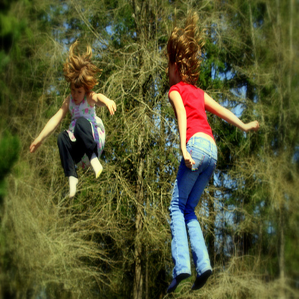

In [ ]:
img, cap = train_dataset[12]
print(' '.join([vocab.index2word[i.item()] for i in cap ]))
model.eval()
with torch.no_grad():
  print(model.image_caption(img.unsqueeze(0).to(device), 20))
untransform(img)  

Epoch: 0, Step: 0, Loss:2.70955


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


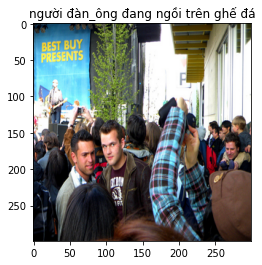

Epoch: 0, Step: 500, Loss:2.75199


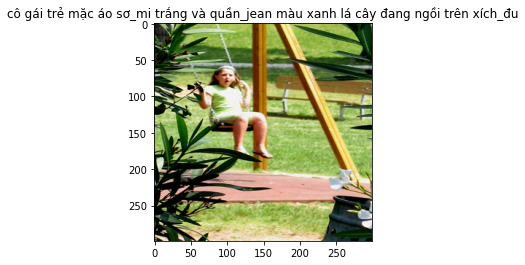

Epoch: 0, Step: 1000, Loss:2.74498


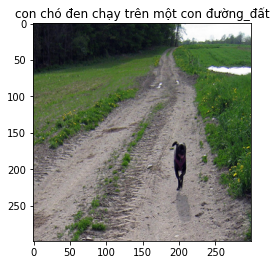

Epoch: 1, Step: 0, Loss:2.71436


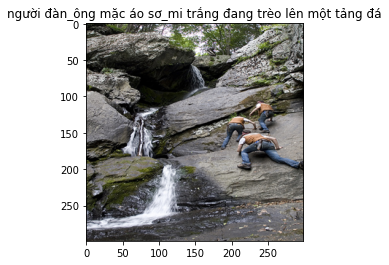

Epoch: 1, Step: 500, Loss:2.63035


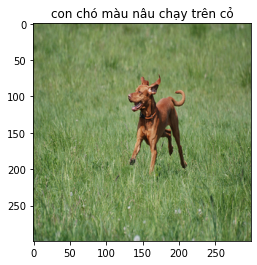

Epoch: 1, Step: 1000, Loss:2.61965


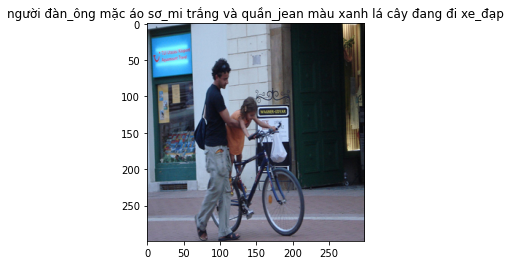

Epoch: 2, Step: 0, Loss:2.59988


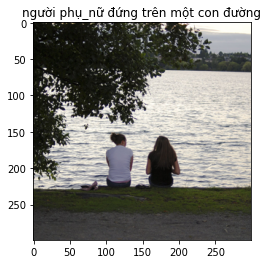

Epoch: 2, Step: 500, Loss:2.53168


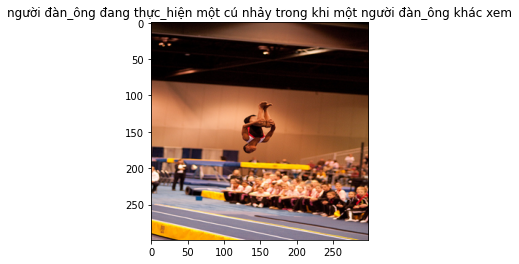

Epoch: 2, Step: 1000, Loss:2.53446


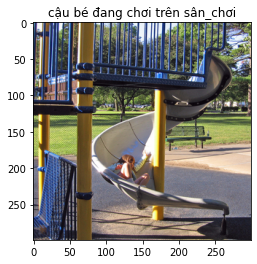

In [ ]:
lst_loss = []
steps_loss = []
epochs = 10
for epoch in range(epochs):
  model.train()
  #model.encoder.eval()

  for i, (images, captions) in enumerate(train_dataloader):

    captions_target = captions[:,1:].to(device)
    captions_train = captions[:,:-1].to(device)
    images = images.to(device)

    model.zero_grad()

    outputs,atten_weight = model(captions = captions_train, images = images)

    loss = criterion(outputs.view(-1,vocab.n_words), captions_target.reshape(-1))

    loss.backward()
    optimizer.step()

    steps_loss.append(loss.item())

    if i %500 ==0:
      print(f'Epoch: {epoch}, Step: {i}, Loss:{np.array(steps_loss).mean():.5f}')
      lst_loss.append(np.array(steps_loss).mean)
      steps_loss =[]

      # print result 
      ii = random.randint(0,len(test_dataset)-1)
      model.eval()
      with torch.no_grad():
        image = test_dataset[ii][0]
        cap = model.image_caption(image.unsqueeze(0).to(device), 20)
        plt.imshow(untransform(image))
        plt.title(cap)
        plt.pause(0.001)
      model.train()
  torch.save(model.state_dict(),'/content/drive/MyDrive/DeepLearning/TH/CuoiKy/ImageCaption/modellllllll.pth')
    

In [ ]:
torch.save(model.state_dict(),'/content/drive/MyDrive/DeepLearning/TH/CuoiKy/ImageCaption/modellllllll.pth')

# Fail!!!!

In [ ]:
# class EncoderCNN(nn.Module):
#   def __init__(self, embed_size):
#     super(EncoderCNN,self).__init__()
#     self.inception = torchvision.models.inception_v3(pretrained=True, aux_logits = False)
#     self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
#     self.relu = nn.ReLU()
#     self.dropout = nn.Dropout(0.4)
#   def forward(self, images):
#     features = self.inception(images)
#     for named, parameters in self.inception.named_parameters():
#       if 'fc.weight' in named or 'fc.bias' in named:
#         parameters.requires_grad = True
#       else:
#         parameters.requires_grad = False
#     return self.dropout(self.relu(features))


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


In [ ]:
class DecoderLSTM(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size, num_layers,embedding_matrix):
    super(DecoderLSTM,self).__init__()

    self.embed = nn.Embedding(vocab_size, embed_size)
    self.embed.weight = nn.Parameter(torch.from_numpy(embedding_matrix))
    self.embed.weight.request_grad = False
    
    self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first = True)
    self.linear = nn.Linear(hidden_size, vocab_size)
    self.dropout = nn.Dropout(0.5)

  def forward(self,features, descriptions):
    embeddings = self.embed(descriptions)

    # features se la input cua mang decoder
    features = features.unsqueeze(1)
 


    x = torch.cat((features, embeddings[:,:-1,:]), dim = 1)
    x, _ = self.lstm(x)
    x = self.linear(x)
    return x

In [ ]:
class EncoderDecoder(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size, num_layers, embedding_matrix):
    super(EncoderDecoder,self).__init__()
    self.encoder = EncoderCNN(embed_size)
    self.decoder = DecoderLSTM(embed_size, hidden_size, vocab_size,num_layers,embedding_matrix)
  
  def forward(self, images, caption):
    features = self.encoder(images)
    outputs = self.decoder(features, caption)
    return outputs
  def caption_image(self, image, max_length = 20,  vocab_class = VC):
    result_caption = []

    with torch.no_grad():
      x = self.encoder(image).unsqueeze(1)
      print(x.shape)
      states = None
      for _ in range(max_length):
        hiddens,states = self.decoder.lstm(x, states)
        output = self.decoder.linear(hiddens)
        predict = output.argmax(2)
        result_caption.append(predict.item())
        
        x = self.decoder.embed(predict)

        if vocab_class.index2word[predict.item()] =='<endseq>':
          break
      return ' '.join([vocab_class.index2word[i] for i in result_caption])




In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = torchvision.models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features

class DecoderRNN(nn.Module):
    def __init__(self,embed_size, hidden_size, vocab_size, num_layers=1,drop_prob=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,num_layers=num_layers,batch_first=False)
        self.fcn = nn.Linear(hidden_size,vocab_size)
        self.drop = nn.Dropout(drop_prob)
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions[:,:-1])
        
        #concat the features and captions
        x = torch.cat((features.unsqueeze(1),embeds),dim=1) 
        x,_ = self.lstm(x)
        x = self.fcn(x)
        return x
    
    def generate_caption(self,inputs,hidden=None,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = inputs.size(0)
        
        captions = []
        
        for i in range(max_len):
            output,hidden = self.lstm(inputs,hidden)
            output = self.fcn(output)
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.index2word[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            inputs = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.index2word[idx] for idx in captions]
        
            
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, hidden_size, vocab_size, num_layers=1,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size,hidden_size,vocab_size,num_layers,drop_prob)
    
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs


In [ ]:
embed_size = 300
hidden_size = 64
vocab_size = VC.n_words
num_layers = 1
learning_rate = 0.0001
num_epochs = 5

In [ ]:
model = EncoderDecoder(embed_size, hidden_size, vocab_size,num_layers).to(device)
#model.load_state_dict(torch.load('/content/drive/MyDrive/DeepLearning/TH/CuoiKy/ImageCaption/imagecaption.pth'))
criterion = nn.CrossEntropyLoss( ignore_index=VC.word2index['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# ind = 2222
# model.eval()
# with torch.no_grad():
#   print(model.caption_image(train_dataset[ind][0].to(device).unsqueeze(0)))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
num_epochs = 20
print_every = 100
model.train()
for epoch in range(1,num_epochs+1):   
    for idx, (image, captions) in enumerate(iter(train_dataloader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs = model(image, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()
        
        if (idx)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            
            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(test_dataloader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps = model.decoder.generate_caption(features.unsqueeze(0),vocab=VC)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)
            model.train()
                
            
    torch.save(model.state_dict(),'/content/drive/MyDrive/DeepLearning/TH/CuoiKy/ImageCaption/imagecaption.pth')

KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(),'/content/drive/MyDrive/DeepLearning/TH/CuoiKy/ImageCaption/imagecaption.pth')

In [ ]:
dataiter = iter(train_dataloader)
img,_ = next(dataiter)
features = model.encoder(img[0:1].to(device))
caps = model.decoder.generate_caption(features.unsqueeze(0),vocab=VC)
caption = ' '.join(caps)
caption

'<startseq> người đàn_ông mặc áo đỏ đang chạy trên một con chó màu nâu <endseq> <endseq> <endseq> <endseq> <endseq> <endseq>'

In [ ]:
#for image plot
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
show_image(img[30],title=caption)

<startseq> cô gái mặc màu hồng treo trên vòng <endseq>
tensor([  1,  17,  18,   5,  37,   7, 810,  40, 800,   2])
torch.Size([1, 1, 300])
<startseq> người đàn_ông mặc áo màu xanh <endseq>


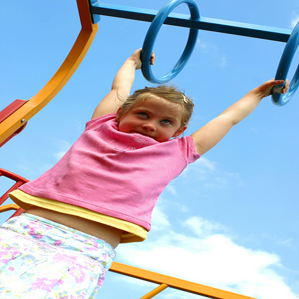

In [ ]:
img, cap = train_dataset[3344]
print(' '.join([VC.index2word[i.item()] for i in cap ]))
print(cap)
print(model.caption_image(img.to(device).unsqueeze(0)))
transforms.ToPILImage()(img)

In [ ]:
print(model.encoder(img.to(device).unsqueeze(0)))

tensor([[16.3776,  0.0000, 11.4775,  3.4885,  8.4259,  9.5733,  0.0000,  0.0000,
          0.0000,  0.0000, 10.0766,  0.0000,  3.3305,  9.5655,  0.0000,  9.5325,
          4.0924,  8.8985, 11.0989,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000, 10.3517,  0.0000,  0.0000,  0.0000, 10.6456, 11.8789,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  8.4158,
          3.5395, 10.3030,  0.0000,  0.0000,  4.5287,  0.0000,  0.0000, 12.0089,
          0.0000,  0.0000, 10.7782,  0.0000,  0.0000,  8.8377,  0.0000,  0.0000,
          0.0000,  9.9775,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  8.8615,
          0.0000,  8.7735,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          8.5730,  7.7434,  5.6799,  0.0000,  3.2710,  0.0000,  0.0000, 13.7747,
          0.0000, 12.5158,  0.0000, 13.3172,  0.0000,  0.0000,  0.0000, 11.6544,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  

In [ ]:
img.shape

torch.Size([3, 299, 299])